In [45]:
### TO RUN
import os

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy

In [46]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [47]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

birds
chainsaw
fire
handsaw
helicopter


In [48]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun o

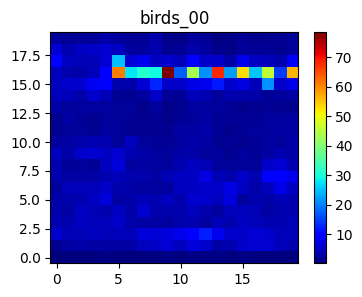

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


In [49]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.2)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol


idx = 0
myds.display(["birds", idx])

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

The ``shift_pct`` introduces a random shift to the audio signal used for generating the feature vectors. When ``shift_pct`` is set to ``0.0``, there is no random shift applied to the audio signal (the feature vectors are always comptuded starting from the beginning of the sound, so it looks the same every execution). When ``shift_pct`` is set to ``0.2``, the audio signal is circularly shifted by a random percentage of its length, up to 20% of the total signal duration. This randomness in time-shifting can be useful for data augmentation as it prevents overfitting by introducing variety (temporal diversity) into the dataset.

In [50]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7

featveclen = len(myds["fire", 0])  # number of items in a feature vector
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
nlearn = round(naudio * train_pct)  # number of sounds among naudio for training

data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio * data_aug_factor)

"Compute the matrixed dataset, this takes some seconds, but you can then reload it by commenting this loop and decommenting the np.load below"
X = np.zeros((data_aug_factor * nclass * naudio, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = myds[classname, idx]
            X[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)

# X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")

print(
    "Remember the convention shown for the toy example, the feature vectors are arranged on the rows."
)

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


Shape of the feature matrix : (200, 400)
Number of labels : 200
Remember the convention shown for the toy example, the feature vectors are arranged on the rows.


You might notice that ``feature_matrix_2D.npy`` has been saved in ``data/feature_matrices/`` and can now be loaded instead of recomputing it at every run.

<font size=5 color=#009999> 2.2. First audio classification, metrics and dataset splitting </font> <br>

For now we have only prepared the dataset, it remains to feed it to the classifiers. <br>

In [51]:
### TO RUN
K = 6  # Number of neighbours for the KNN
model_knn = KNeighborsClassifier(
    n_neighbors=K, weights="distance", algorithm="auto", metric="minkowski"
)  # We explicitly write the default parameters of this KNN classifier once so that you know they exist and can be changed

model_lda = LDA(
    solver="svd",
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None,
)  # We explicitly write the default parameters of this LDA classifier once so that you know they exist and can be changed

As for the toy example, we keep the ``accuracy`` and ``confusion matrix`` as performance metrics. <br>

Note that here we are not especially interested in a model selection hence we only split the dataset in training and testing parts but we don't split the training set in learning/validation parts. The models are trained on the entire training set.

Shape of the training matrix : (140, 400)
Number of training labels : 140
Accuracy of KNN with fixed train/validation sets : 58.3%


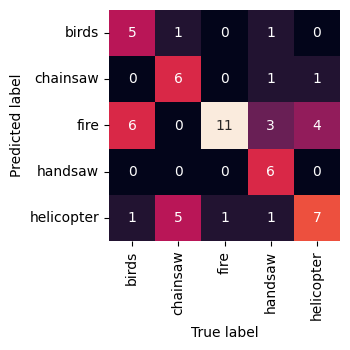

Accuracy of LDA with fixed train/validation sets : 35.0%


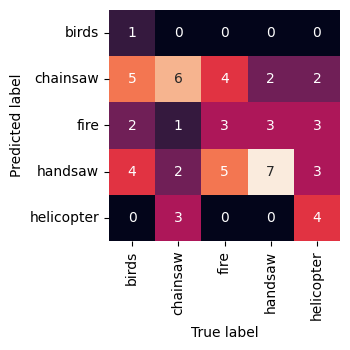

In [52]:
### TO RUN
"Shuffle then split the dataset into training and testing subsets"
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)  # random_state=1
print(f"Shape of the training matrix : {X_train.shape}")
print(f"Number of training labels : {len(y_train)}")

model_knn.fit(X_train, y_train)
model_lda.fit(X_train, y_train)

prediction_knn = model_knn.predict(X_test)
prediction_lda = model_lda.predict(X_test)
accuracy_knn = accuracy(prediction_knn, y_test)
accuracy_lda = accuracy(prediction_lda, y_test)

print(f"Accuracy of KNN with fixed train/validation sets : {100 * accuracy_knn:.1f}%")
show_confusion_matrix(prediction_knn, y_test, classnames)
print(f"Accuracy of LDA with fixed train/validation sets : {100 * accuracy_lda:.1f}%")
show_confusion_matrix(prediction_lda, y_test, classnames)

**Questions**: 
- What would be the expected accuracy if the label predictions were picked at random?
- What do you observe in this confusion matrix? Run again the cell above, i.e., Reapply the ``train_test_split`` and tell if your observations are robust.

**Answers to the Questions**: 

-If the label predictions were picked randomly, the expected accuracy depends on the class distribution in the dataset. Here, we have 5 classes, the expected accuracy is ``20%``.

-For the first execution, the results are very bad for both classifier (even if the KNN results are a bit better). There are no perfect detection whatever the class. There is no significantly ameloriations in the results since the dataset on which the training is effectued doesn't change (the results may change a bit since the training set is chosen randomly in all dataset). We see a tendance for the confusion matrix, in fact we are classifying a lot of item in the fire class (à expliquer pourquoi).

Play with the ``classname`` and the index ``idx`` to pick feature vectors in the dataset ``myds``, listen to the audio associated to the feature vector, and check if you would have been able to predict the right class by your own. Then compare with the prediction given by your classifier.

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun o

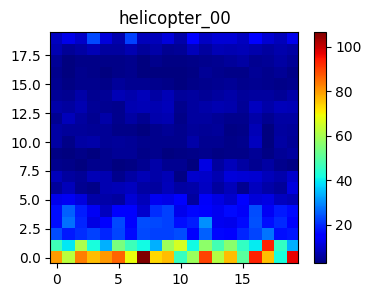

Class predicted by KNN: helicopter
Class predicted by LDA: chainsaw


In [53]:
### TO RUN
idx = 0
classname = "helicopter"
myds.display([classname, idx])
thisfv = myds[classname, idx].reshape(-1)

# this artefact is necessary because the 'predict' function expects a matrix_like input.
mat = np.zeros((2, len(thisfv)))
mat[0] = thisfv

prediction_knn = model_knn.predict(mat)
prediction_lda = model_lda.predict(mat)

print("Class predicted by KNN:", prediction_knn[0])
print("Class predicted by LDA:", prediction_lda[0])

Furthermore, when training a model and comparing different settings, there is a risk that we will end up choosing optimal parameters that only render good result on our specific case of training and validation set, but ``do not generalize well for additional data``. This is called ``overfitting on the validation set``. To alleviate this, we can perform ``cross-validation (CV)``. A basic approach named ``K-fold CV`` involves partitioning the dataset in ``K`` "folds" (subsets) and repetitvely do the following procedure:

- Train the model using `K-1` folds as the training data.
- Test the model using the last fold as the validation data.

The overall performance on each fold is then averaged to obtain the final performance metrics.

In [54]:
### TO RUN
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)

accuracy_knn = np.zeros((n_splits,))
accuracy_lda = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_train, y_train)):
    (idx_learn, idx_val) = idx
    model_knn.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_knn = model_knn.predict(X_train[idx_val])
    accuracy_knn[k] = accuracy(prediction_knn, y_train[idx_val])

    model_lda.fit(X_train[idx_learn], y_train[idx_learn])
    prediction_lda = model_lda.predict(X_train[idx_val])
    accuracy_lda[k] = accuracy(prediction_lda, y_train[idx_val])

print(f"Mean accuracy of KNN with 5-Fold CV: {100 * accuracy_knn.mean():.1f}%")
print(
    f"Std deviation in accuracy of KNN with 5-Fold CV: {100 * accuracy_knn.std():.1f}%"
)

print(f"Mean accuracy of LDA with 5-Fold CV: {100 * accuracy_lda.mean():.1f}%")
print(
    f"Std deviation in accuracy of LDA with 5-Fold CV: {100 * accuracy_lda.std():.1f}%"
)

Mean accuracy of KNN with 5-Fold CV: 42.1%
Std deviation in accuracy of KNN with 5-Fold CV: 5.2%
Mean accuracy of LDA with 5-Fold CV: 33.6%
Std deviation in accuracy of LDA with 5-Fold CV: 4.3%


There a small amelioration in the results with K-folding.

<font size=5 color=#009999> 2.3. Scale mismatch and countermeasure </font> <br>

In real conditions, you will most probably have a different scale between the feature vectors used for training (in simulation) and the ones you feed in your model to make predictions.
This scale mismatch between model training and prediction is difficult to prevent because it depends on multiple factors such as the audio source power, its distance to the microphone, the telecommunication distance. <br>

Below, we illustrate the link between the volume of the audio and its distance to the origin of the feature space. At different emission distances, the exact same sound would be heard at a different volume and the associated feature vector would be located at another position in the *feature space*. Eventually, this would result in a completely different classification, which is undesirable.

<center> <img src="figs/norms.png" alt="" width="350"/> </center>

### Questions:

- How could you avoid this dependency on the volume of the sound?
- What is represented in the hatched centered area? How would you classify feature vectors in this area?

-Normalizing the data : Apply normalization to ensure all feature vectors are scaled consistently. This removes magnitude dependencies from the feature space.

-The hatched centered area in the image likely represents a region in the feature space where the feature vectors have low magnitude.This could correspond to audio signals with very low power. It may indicate noise or silence, as very low-energy signals (close to the origin) may not carry meaningful information about the audio source. (This region might also include outliers or invalid inputs that do not fit into any of the defined classes.)

1.Reject as "Unclassifiable":
If the hatched area corresponds to non-informative or ambiguous signals, feature vectors in this region can be classified as "unknown" or "unclassifiable."

2.Assign to a Default Class:
In some applications, low-energy signals might be assigned to a default class, such as "background noise."

3.Preprocessing Exclusion:
Feature vectors that fall within this region can be excluded during preprocessing, ensuring only meaningful signals are passed to the classifier.

4.Use a Confidence Threshold:
If the classification model assigns low confidence to vectors in this region, a rejection mechanism can be implemented to handle them appropriately.

Play with the ``dB_mismatch`` variable here below and observe its effect on the confusion matrix.

On which part of the dataset are we computing this confusion matrix?

We work on idx_val which corresponds to the validation part of the dataset.
dB_mismatch represents the difference in decibel (dB) scale between the training data (X_train) and the validation data (X_val_scaled).
It models a mismatch in the amplitude scaling of the feature vectors used during training and testing.
dB_mismatch = 0: No mismatch; the training and validation data have the same scale.
Positive values (e.g., dB_mismatch = 5): Validation features are scaled down (quieter sounds), simulating a mismatch where test data is quieter than the training data.
Negative values (e.g., dB_mismatch = -5): Validation features are scaled up (louder sounds).

When dB_mismatch is small (close to 0):
The scaled validation data closely matches the training data.
The confusion matrix will likely show strong diagonal dominance (correct classifications).
When dB_mismatch increases:
The scaled validation data deviates significantly from the training data.
The classifier may misclassify samples, leading to off-diagonal entries in the confusion matrix and reduced classification accuracy.

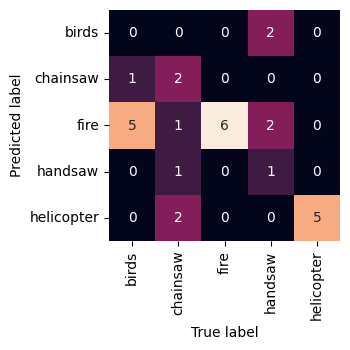

Accuracy of KNN: 50.0%


In [55]:
### TO RUN
dB_mismatch =0  # Play with this value
X_val_scaled = X_train[idx_val] * 10 ** (-dB_mismatch / 20)

model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train[idx_learn], y_train[idx_learn])
prediction_knn = model_knn.predict(X_val_scaled)
show_confusion_matrix(prediction_knn, y_train[idx_val], classnames)
accuracy_knn = accuracy(prediction_knn, y_train[idx_val])
print(f"Accuracy of KNN: {100 * accuracy_knn:.1f}%")

The simplest countermeasure we can think of is to normalise the feature vector (i.e. unitize its norm) prior to use, both for training and testing. Remember how this normalization could be visualized in ``hands_on_classif1_toy_student.ipynb`` <br>
Play again with the ``dB_mismatch`` variable here below and observe its effect on the confusion matrix.

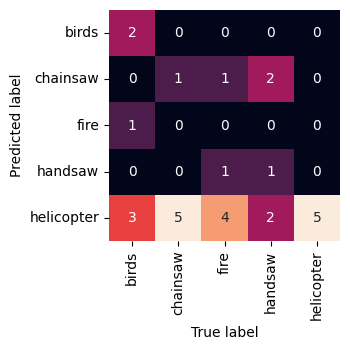

Accuracy of KNN: 32.1%


In [56]:
### TO RUN
dB_mismatch = 0  # Play with this value

X_learn_normalised = X_train[idx_learn] / np.linalg.norm(
    X_train[idx_learn], axis=1, keepdims=True
)
model_knn = KNeighborsClassifier(n_neighbors=10, weights="distance")
model_knn.fit(X_learn_normalised, y_train[idx_learn])

X_val_scaled = X_train[idx_val] * 10 ** (-dB_mismatch / 20)
X_val_normalised = X_val_scaled / np.linalg.norm(X_val_scaled, axis=1, keepdims=True)

prediction_knn = model_knn.predict(X_val_normalised)
show_confusion_matrix(prediction_knn, y_train[idx_val], classnames)
accuracy_knn = accuracy(prediction_knn, y_train[idx_val])
print(f"Accuracy of KNN: {100 * accuracy_knn:.1f}%")

Thanks to the normalization, there is no changes in the results with a different value for the dB_mismatch.
The simplest and most effective countermeasure against dB_mismatch is to normalize the feature vectors so that their norms are always the same. This ensures that the model becomes invariant to changes in scale (e.g., volume differences) between training and testing data.
After normalization, the confusion matrix will retain strong diagonal dominance, and the classification accuracy will remain stable.

**Question**: 
- What will happen with this normalisation countermeasure when there is no sound around the microphone? Is this desirable? How could you deal with it?

If the vector contains only small numerical noise (near-zero values), normalization can amplify this noise, 
creating a misleading unit-norm vector that does not represent meaningful audio content.
If there is nothing in the sound (only the noise), it will have a very strong feature vector because we normalize with something very small
(dividing something by something very small has a very big result).
We should only normalize if the enrgy is heigher than a specified threshold, everything below the threshold could go into the garbage class.

<font size=5 color=#009999> 2.4. Dimensionality reduction </font> <br>

It is sometimes good practice to reduce the dimensionality of a signal in order to get the main components of their distribution. A motivation is that usual norms behave counter-inuitively in high dimension. It also further reduces the memory cost of the feature vector. To reduce the dimensionality, we will use the ``Principal component analysis (PCA)`` proposed by sklearn. See the [associated Wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis). Recall: the PCA consists in reducing the dimensionality of data vectors encoded in $\boldsymbol X \in \mathbb R^{d\times N}$ to only $p \ll d$ dimensions as

$$
    \boldsymbol Y = \boldsymbol V_p^\top \boldsymbol X \in \mathbb R^{p\times N},
$$

where the SVD of the covariance matrix writes as $\hat{\boldsymbol\Sigma}_{\boldsymbol X} = \frac{1}{d} \boldsymbol{XX}^\top = \boldsymbol{U\Sigma V}^\top$, and $\boldsymbol V_p$ is the subselection of the first $p$ columns of $\boldsymbol V$. 

For our application, reducing the dimensionality of the data can be helpful for compressing the packet size to be transmitted wirelessly. Indeed, once learned during training, $\boldsymbol V_p$ can be hardcoded on the transmitter side.

Starting with a PCA to 2D for visualization, see how hard it is to separate the classes.

Shape of the reduced training matrix : (112, 2)


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


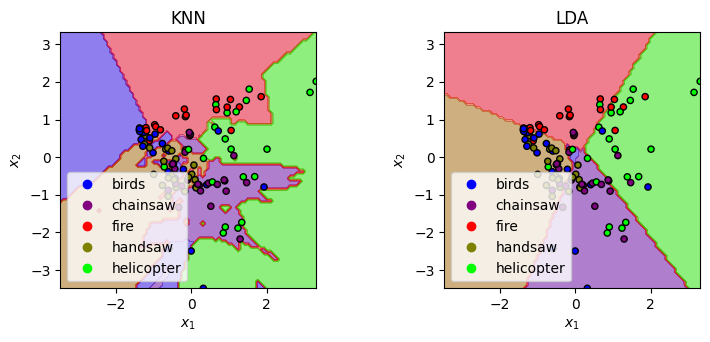

In [57]:
### TO RUN
n = 2  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
X_learn_reduced = pca.fit_transform(X_train[idx_learn])
X_val_reduced = pca.transform(X_train[idx_val])

print(f"Shape of the reduced training matrix : {X_learn_reduced.shape}")

y_train_num = np.zeros(y_train.shape)
for i, classname in enumerate(classnames):
    y_train_num[y_train == classname] = i

K = 10
model_knn = KNeighborsClassifier(n_neighbors=K)
model_knn.fit(X_learn_reduced, y_train_num[idx_learn])
prediction_knn = model_knn.predict(X_val_reduced)
accuracy_knn = accuracy(prediction_knn, y_train_num[idx_val])

model_lda = LDA()
model_lda.fit(X_learn_reduced, y_train_num[idx_learn])
prediction_lda = model_lda.predict(X_val_reduced)
accuracy_lda = accuracy(prediction_lda, y_train_num[idx_val])

fig = plt.figure()
axs = [fig.add_axes([0.0, 0.0, 0.4, 0.9]), fig.add_axes([0.6, 0.0, 0.4, 0.9])]
plot_decision_boundaries(
    X_learn_reduced,
    y_train_num[idx_learn],
    ax=axs[0],
    model=model_knn,
    legend=classnames,
    title="KNN",
)
plot_decision_boundaries(
    X_learn_reduced,
    y_train_num[idx_learn],
    ax=axs[1],
    model=model_lda,
    legend=classnames,
    title="LDA",
)
plt.show()

**Question**: 
- From the decision boundaries shown here above, can you explain why the ``handsaw`` class is less often chosen than the other classes for the ``KNN`` classifier?

We can see that the points of handsaw (same observation for the green ones) are not contained in a small area but are scattered everywhere. This can be explained by the fact the space chosen isn't adapt to differentiate the handsaw and helicopter classes (but okay for birds, chainsaw fire). So to differentiate these two classes, we should choose another space.

Shape of the reduced learning matrix : (112, 5)
Accuracy of the KNN : 50.0%


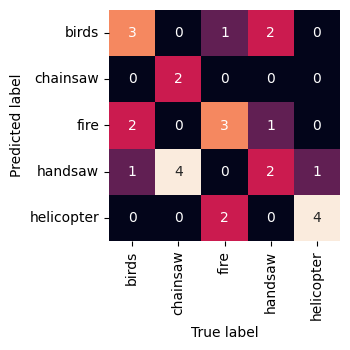

Accuracy of the LDA : 39.3%


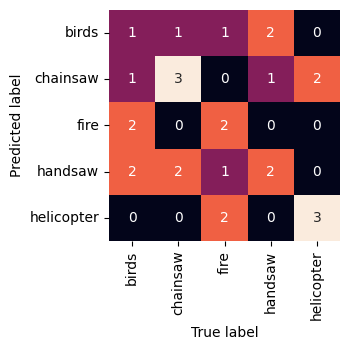

In [58]:
### TO RUN
n = 5  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
X_learn_reduced = pca.fit_transform(X_train[idx_learn])
X_val_reduced = pca.transform(X_train[idx_val])

#Export the pca via pickle
with open(model_dir + "pca.pickle", "wb") as f:
    pickle.dump(pca, f)

print(f"Shape of the reduced learning matrix : {X_learn_reduced.shape}")

K = 10
model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")
model_knn.fit(X_learn_reduced, y_train[idx_learn])
prediction_knn = model_knn.predict(X_val_reduced)
accuracy_knn = accuracy(prediction_knn, y_train[idx_val])

model_lda = LDA()
model_lda.fit(X_learn_reduced, y_train[idx_learn])
prediction_lda = model_lda.predict(X_val_reduced)
accuracy_lda = accuracy(prediction_lda, y_train[idx_val])

print(f"Accuracy of the KNN : {100 * accuracy_knn:.1f}%")
show_confusion_matrix(prediction_knn, y_train[idx_val], classnames)
print(f"Accuracy of the LDA : {100 * accuracy_lda:.1f}%")
show_confusion_matrix(prediction_lda, y_train[idx_val], classnames)

<font size=5 color=#009999> 2.5. Analysis of the hyperparameters </font> <br>

Finally, we can inspect the influence of ``hyperparameters`` as we did for the toy example. <br>
Let us start by analyzing the influence of the number of neighbours $K$ in the KNN. 

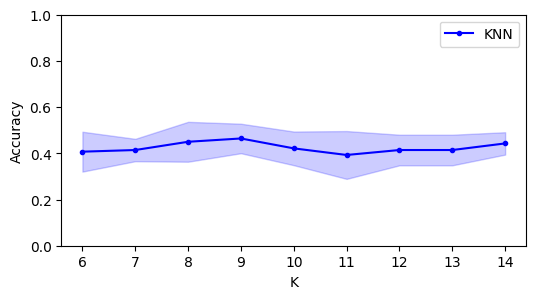

In [59]:
### TO RUN
Ks = np.arange(6, 15, 1)
accuracies_knn = np.zeros((len(Ks), n_splits))
for i, K in enumerate(Ks):
    model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")
    for k, idx in enumerate(kf.split(X_train, y_train)):
        (idx_learn, idx_val) = idx
        model_knn.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_knn = model_knn.predict(X_train[idx_val])
        accuracies_knn[i, k] = accuracy(prediction_knn, y_train[idx_val])
means_knn = accuracies_knn.mean(axis=1)
stds_knn = accuracies_knn.std(axis=1)

"Plot"
plt.figure(figsize=(6, 3))
plt.plot(Ks, means_knn, ".-b", label="KNN")
plt.fill_between(Ks, means_knn - stds_knn, means_knn + stds_knn, alpha=0.2, color="b")
plt.ylim(0, 1)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Here we consider both ``K`` and the number of principal components ``n``.

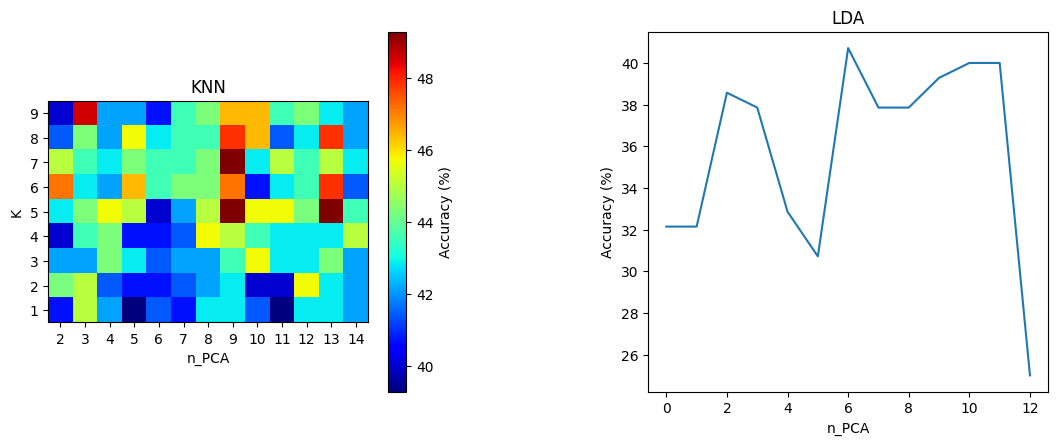

In [60]:
### TO RUN
Ks = np.arange(1, 10)
n_comps = np.arange(2, 15)  # number of principal components kept for the PCA
accuracies_knn = np.zeros((len(Ks), len(n_comps)))
accuracies_lda = np.zeros(len(n_comps))

for j, n in enumerate(n_comps):
    for idx_learn, idx_val in kf.split(X_train, y_train):
        pca = PCA(n_components=n, whiten=True)
        X_learn_reduced = pca.fit_transform(X_train[idx_learn])
        X_val_reduced = pca.transform(X_train[idx_val])
        for i, K in enumerate(Ks):
            model_knn = KNeighborsClassifier(n_neighbors=K)
            model_knn.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_knn = model_knn.predict(X_train[idx_val])
            accuracies_knn[i, j] += accuracy(prediction_knn, y_train[idx_val])

        model_lda = LDA()
        model_lda.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_lda = model_lda.predict(X_train[idx_val])
        accuracies_lda[j] += accuracy(prediction_lda, y_train[idx_val])

accuracies_knn /= n_splits
accuracies_lda /= n_splits

fig = plt.figure(figsize=(10, 4))
axs = [fig.add_axes([0.0, 0.0, 0.4, 0.9]), fig.add_axes([0.6, 0.0, 0.4, 0.9])]

im0 = axs[0].imshow(100 * accuracies_knn, cmap="jet", origin="lower")
cbar = fig.colorbar(im0, ax=axs[0])
cbar.set_label("Accuracy (%)")
axs[0].set_xlabel("n_PCA")
axs[0].set_ylabel("K")
axs[0].set_xticks(list(np.arange(len(n_comps))))
axs[0].set_xticklabels(list(n_comps))
axs[0].set_yticks(list(np.arange(len(Ks))))
axs[0].set_yticklabels(list(Ks))
axs[0].set_title("KNN")

axs[1].plot(accuracies_lda * 100)
axs[1].set_xlabel("n_PCA")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("LDA")
plt.show()

**Question**: 
- Do you observe some dependency of the accuracy on these parameters? If so, which one(s)? If not, discuss what it tells about the considered model. 

-For KNN and LDA:
Accuracy fluctuates depending on the choice of K. (generally lower values of K gives better results since we look at less neighbours).
The number of PCA components significantly impacts accuracy. For instance, accuracy is higher for 7 and 8, indicating that the reduced dimensionality retains relevant features while filtering out noise. Too few or too many components might underfit or overfit the data.
Generaly, we don't see a tendance when the parameters are increased, this could be explained by the fact that the classifier isn't adapted to the dataset. However, depending on the final dataset, we should have an opitmal dimension and number of neighbours that sould allow us to have a better accuracy.

<font size=5 color=#009999> 2.6. Augmenting the data </font> <br>

In order to make our classifier more robust to some common transformations of the audio signal such as ``time shift``, ``AWGN``, or a ``transfer function``, an idea consists in feeding the classifier with such transformations. A popular approach is to create new feature vectors based on transformed versions of the sounds from the original dataset, this is called ``data augmentation``. Data augmentation is also often used when there is few data to train a model. <br>

The functions to augment your data are written in ``utils/audio_student.py``, we already implemented ``time_shift``, ``echo`` and ``spectro_aug_timefreq_masking`` for you. Try to implement ``scaling``, ``add_noise``, ``filter``, ``add_bg`` and even more data augmentation techniques if you want, and check their working in the cell below. <br>

<u>Tip</u>: to avoid restarting the notebook kernel for each modification, you can temporarily insert the ``AudioUtil`` class in a new cell and make your tests until it is working as expected. 

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun o

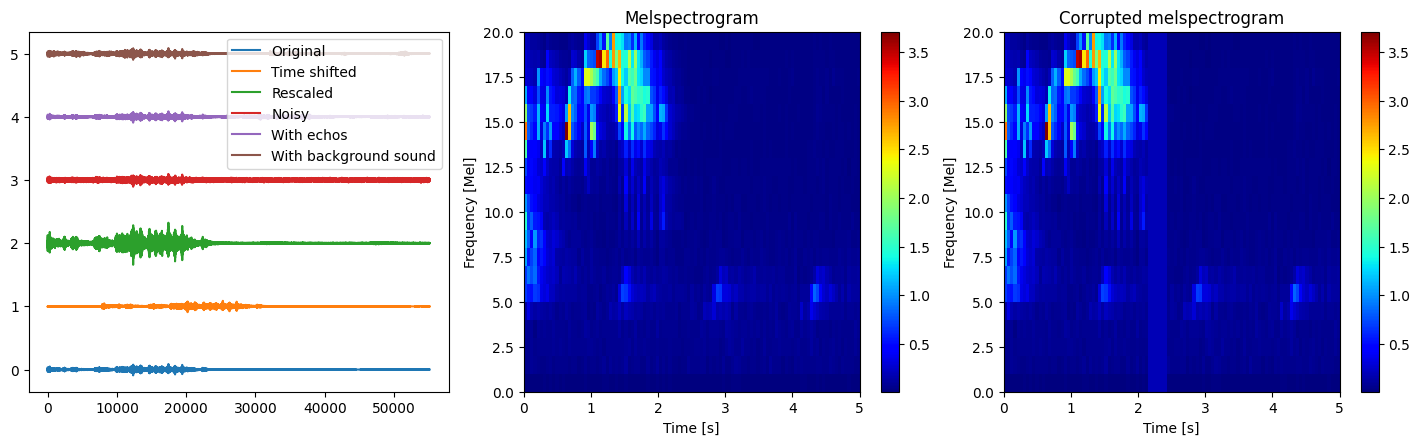

In [61]:
### TO RUN
myds.data_aug = None  # Ensure

cls_index = ["birds", 4]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)

audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.3)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio2, sigma=1e-2)
audio6 = AudioUtil.echo(audio2, 3)
audio7 = AudioUtil.add_bg(audio2, dataset)

AudioUtil.play(audio7)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1, label="Time shifted")
ax1.plot(audio4[0] + 2, label="Rescaled")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4, label="With echos")
ax1.plot(audio7[0] + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

We can now create a new augmented dataset and observe if the classification results improve. 

In [119]:
### TO RUN
myds.mod_data_aug(["original","add_bg", "scaling", "time_shift", "add_noise", "add_echo"])
#y_aug = np.repeat(classnames, dataset.naudio * myds.data_aug_factor)  # original implem = wrong !!


"Compute the matrixed dataset, this takes some seconds, but you can then reload it by commenting this loop and decommenting the np.load below"
X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))
y_aug = np.empty((myds.data_aug_factor * nclass * naudio,), dtype=object)
for s in range(myds.data_aug_factor):
    for idx in range(dataset.naudio):
        for class_idx, classname in enumerate(classnames):
            #print(classname, idx)
            featvec = myds[classname, idx]
            X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
            y_aug[s * nclass * naudio + class_idx * naudio + idx] = classname

y_aug = np.array(y_aug)
"""
np.save(fm_dir + "feature_matrix_2D_aug.npy", X_aug, allow_pickle=True)
np.save(fm_dir + "labels_aug.npy", y_aug, allow_pickle=True)
"""
#X_aug = np.load(fm_dir+"feature_matrix_2D_aug.npy", allow_pickle=True)
#y_aug = np.load(fm_dir+"labels_aug.npy", allow_pickle=True)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

Shape of the feature matrix : (1400, 400)
Number of labels : 1400


Mean accuracy with 5-Fold CV: 78.7%
Std deviation in accuracy with 5-Fold CV: 4.6%


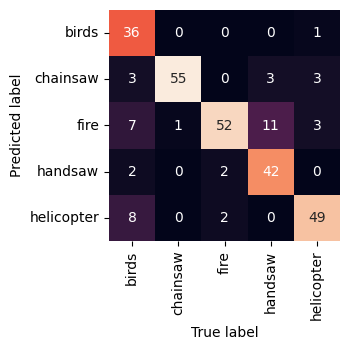

In [110]:
### TO RUN
K = 10  # Number of neighbours
model = KNeighborsClassifier(n_neighbors=K)

accuracy_aug = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_aug, y_aug)):
    (idx_train, idx_test) = idx
    model.fit(X_aug[idx_train], y_aug[idx_train])
    prediction_aug = model.predict(X_aug[idx_test])
    accuracy_aug[k] = accuracy(prediction_aug, y_aug[idx_test])

print(f"Mean accuracy with 5-Fold CV: {100 * accuracy_aug.mean():.1f}%")
print(f"Std deviation in accuracy with 5-Fold CV: {100 * accuracy_aug.std():.1f}%")
show_confusion_matrix(prediction_aug, y_aug[idx_test], classnames)

**Questions**:
- Can you see an improvement of the classification result compared to the non augmented dataset? Try to interpret your answer by thinking about the distribution of points in a data space (as with the toy example), what does it imply to augment the data in terms of distribution of points in the data space?
- With the ``add_bg`` augmentation technique, where are the additive background signals coming from? It is a good thing?
- What transformations are most likely to be realistic in your application? What is the most efficient way to integrate these alterations in your classification task? ``Hint``: it does not require augmenting your data in Python.

-Yes, augmenting the data improve the classifier's performance: from 50% accuracy to 80% accuracy when all augmentations are done, especially when training on small datasets. 
By introducing transformations like time shift, noise, or adding background sounds, the classifier learns to generalize better 
to unseen variations of the input data.
Data augmentation enriches the dataset by effectively increasing its size. This helps spread the data points in the feature space, reducing overfitting to the training set. For example, without augmentation, the classifier might memorize a specific pattern in the feature space. By augmenting the data, the decision boundaries become more robust to variations, ensuring better generalization to test data.
Augmented data increases the diversity in the data space, creating overlapping clusters for the same class, which smoothens the decision boundaries. This makes the classifier more robust to noise or real-world distortions.

-The additive background signals in the add_bg function are sourced from other audio files in the dataset. These files could include ambient noise, other classes' samples, or external background sounds.
It can be good if the background signals realistically simulate the environment where the classifier is intended to operate.
For example, introducing crowd noise for speaker identification in conferences improves real-world performance. In our case, we can consider adding noise of the rain, wind, people walking in the forest,...
MARTIN - CORRECTION: if the background sounds are coming from our training dataset, it could mix a signal with multiple sounds to be recognized, which could be bad for the training (à vérifier!)

-Adding white noise since there is always noise when we receive a signal.
Background noise can be very insteresting like explained on the previous point.
Echo is not very interesting since we are receiving sounds from outside and not inside a room.
-The most efficient way to incorporate these transformations is by performing data augmentation on-the-fly during training, instead of pre-generating all the augmented data. On-the-fly means that something is done dynamically or in real-time as the process (e.g., training) is happening, rather than being precomputed or prepared beforehand. 
MARTIN - CORRECTION: the best way to transform our data is to record it again with our mic and our mcu, to make our dataset more representative. 

<font size=5 color=#009999> 2.7. Getting it all together </font> <br>

Now that some aspects to be considered during the model training and analysis have been presented, it remains to train and save a final model that will be used for further predictions.

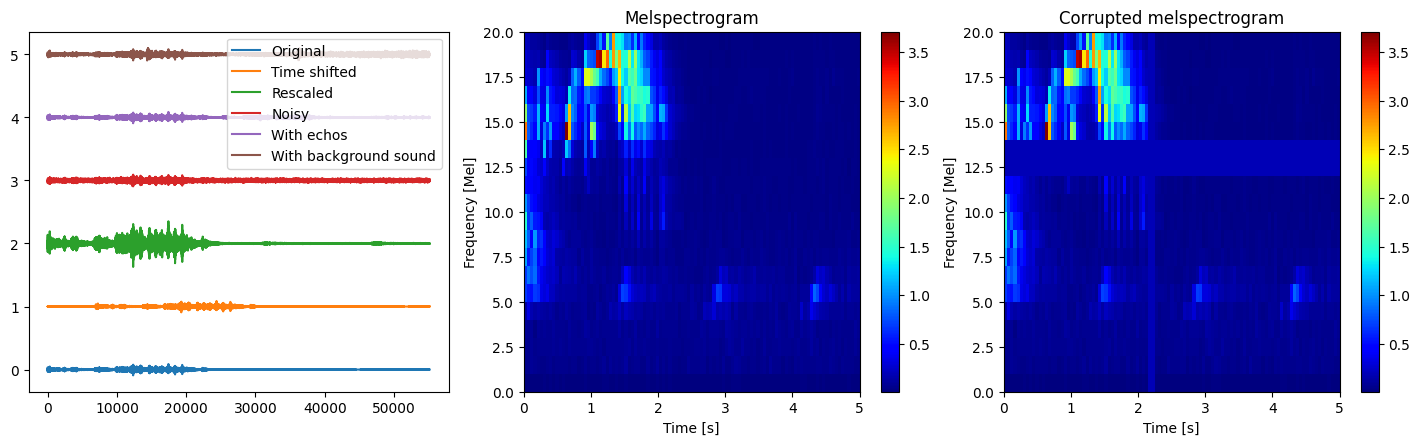

Accuracy of the model : 82.1%


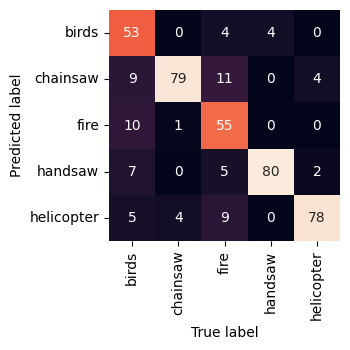

In [121]:
### TO COMPLETE

# [1] Create dataset of feature vectors and split it.
# (optional) with data augmentation
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

### data augmentation
myds.data_aug = None  # Ensure

cls_index = ["birds", 4]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)

#AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.4)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio2, sigma=1e-2)
audio6 = AudioUtil.echo(audio2, 3)
audio7 = AudioUtil.add_bg(audio2, dataset)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1, label="Time shifted")
ax1.plot(audio4[0] + 2, label="Rescaled")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4, label="With echos")
ax1.plot(audio7[0] + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

do_augmentation = False
if do_augmentation:
    X = np.load(fm_dir+"feature_matrix_2D_aug.npy", allow_pickle=True)
    y = np.load(fm_dir+"labels_aug.npy", allow_pickle=True)


# Implementation of a random forest model
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# [2] (optional) Data normalization
X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)
# [3] (optional) dimensionality reduction.
n = 5  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test) #Don't forget to normalize the test set
#X_train_reduced = X_train
#X_test_reduced = X_test


# [4] Model training and selection.
#model = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=None)
model = KNeighborsClassifier(n_neighbors=10, weights="distance")
model.fit(X_train_reduced, y_train)

# [5] Save the trained model, eventually the pca.
filename = "KNN_PCA5.pickle"
pickle.dump(model, open(model_dir + filename, "wb"))

# [6] Evaluate the model.
prediction = model.predict(X_test_reduced)
model_accuracy = accuracy(prediction, y_test)
print(f"Accuracy of the model : {100 * model_accuracy:.1f}%")
show_confusion_matrix(prediction, y_test, classnames)


<font size=5 color=#009999> 2.8. Debriefing </font> <br>
**Questions** : 

1) from what we have done in this notebook, can you already identify some weaknesses in the feature vector computation and classification pipeline? You can make a list here below, and eventually write some short ideas for improvement. This will help you later :)
2) Do you remember what is the time duration of a feature vector? What happens if no sound is produced during the acquisition time of a feature vector?

In [42]:
### TO COMPLETE
# Answer the question above

### Answers - Question 1 

1. Dataset: number of feature matrix and nb of labels can have impact?
2. First audio classification
* Fire have a characteristic found on multiple signals, which lead to misclassification to this class -> to analyse
3. Scaling: Not forget to normalize all dataset, and be carefull that it doesn't reduces our accuracy + add noise treshould for the dump class
4. Find best param for Dimensionality reduction and find the perfect Feature vector space
5. Need a good hyperparameter tuning and adapt the complexity of our model to the number of available data
6. Data augmentation: record again sound with our mic and our mcu + enhance the dataset the most possible by considering reality.


### Question 2 (vérif)
The time duration of a feature vector = nmels * duration ?? If no sound is produced + data normalization, noise could be enhanced -> Need a "dump" class where sounds would be classified when their sound level is under a treshold


